#**Import Library**

In [1]:
!pip install tflite-support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [3]:
import os
import random
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import tensorflow as tf

from google.colab import drive, files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [4]:
print(tf.__version__)

2.17.1


#**Load Data from Drive**

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_dataset = '/content/drive/MyDrive/CAPSTONE PROJECT/coffe_disease_datasets.zip'
zipdata = zipfile.ZipFile(file_dataset, 'r')
zipdata.extractall('dataset')
zipdata.close()

#**Data Exploration**

In [7]:
directory1=os.listdir('./')
print(directory1)

['.config', 'drive', 'dataset', 'sample_data']


In [8]:
directory1=os.listdir('./dataset')
print(directory1)

['test.csv', 'test', 'train.csv', 'train']


In [9]:
list_train_dir = os.listdir('./dataset/train/')
print(list_train_dir)
print(len(list_train_dir))

['phoma', 'miner', 'nodisease', 'rust']
4


In [10]:
training_directory='./dataset/train/'

for  item in list_train_dir:
  class_dir = os.path.join(training_directory,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

phoma  :  388 images
miner  :  332 images
nodisease  :  284 images
rust  :  260 images


phoma


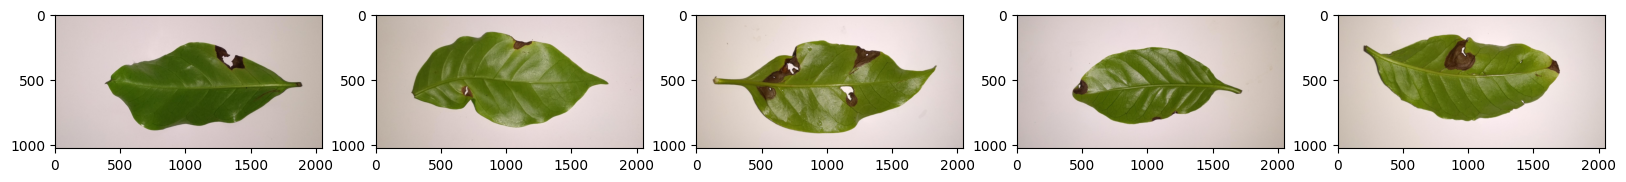

miner


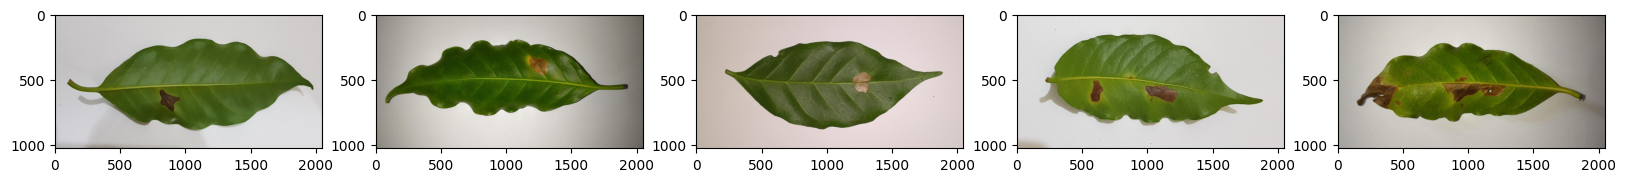

nodisease


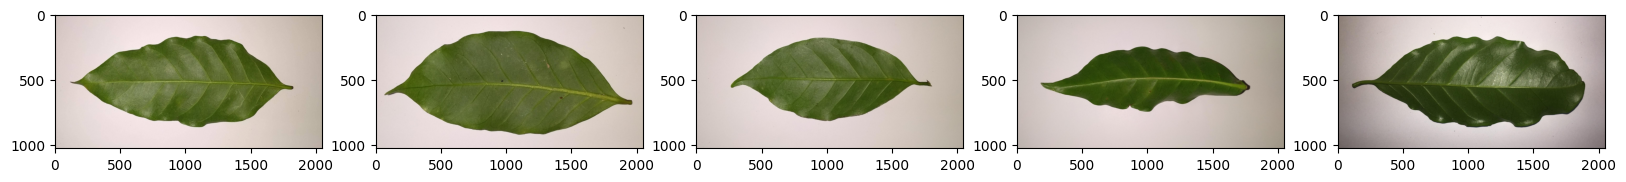

rust


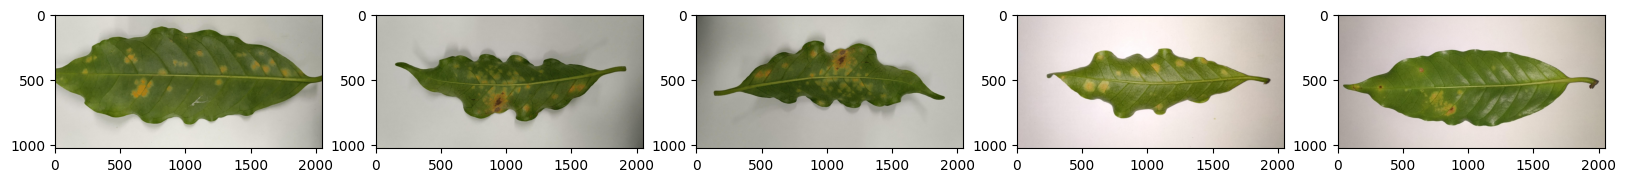

In [11]:
for  images in list_train_dir:
  print(images)
  class_dir = os.path.join(training_directory,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [12]:
list_test_dir = os.listdir('./dataset/test/')
print(list_test_dir)

['phoma', 'miner', 'nodisease', 'rust']


In [13]:
testing_directory='./dataset/test'

for  item in list_test_dir:
  class_dir = os.path.join(testing_directory,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

phoma  :  96 images
miner  :  128 images
nodisease  :  116 images
rust  :  60 images


phoma


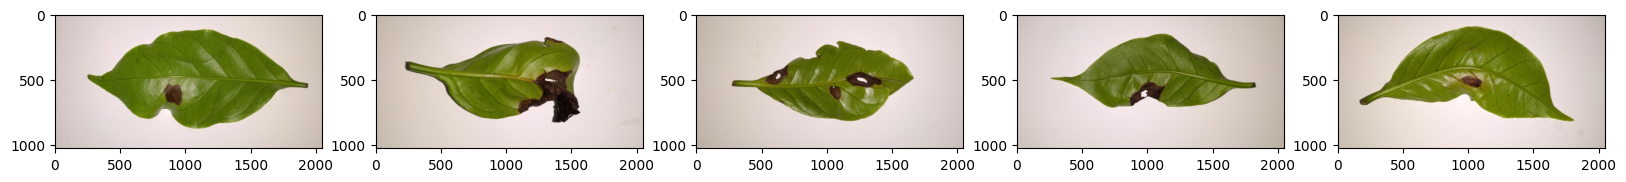

miner


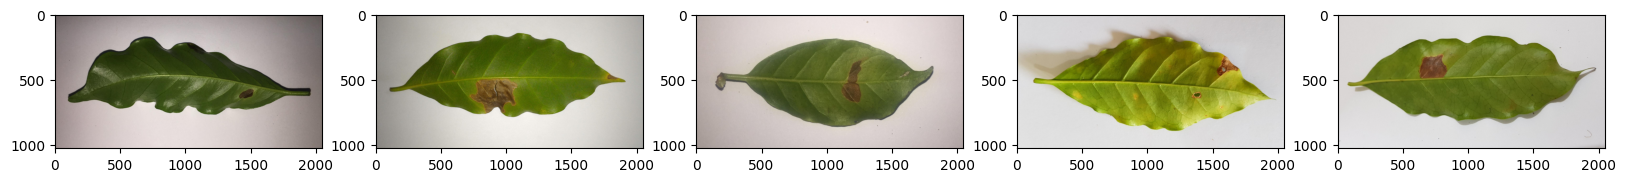

nodisease


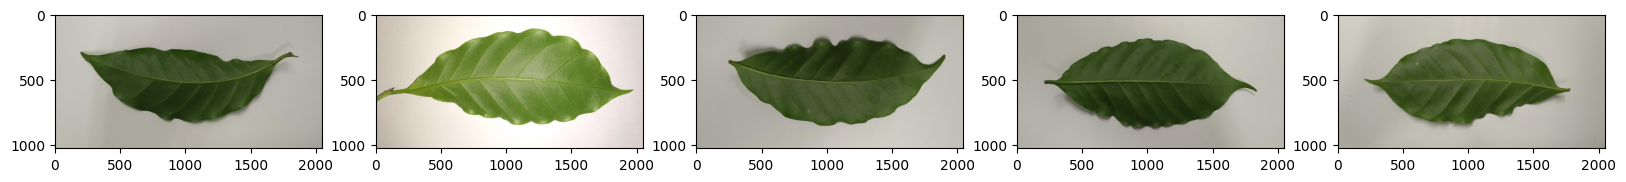

rust


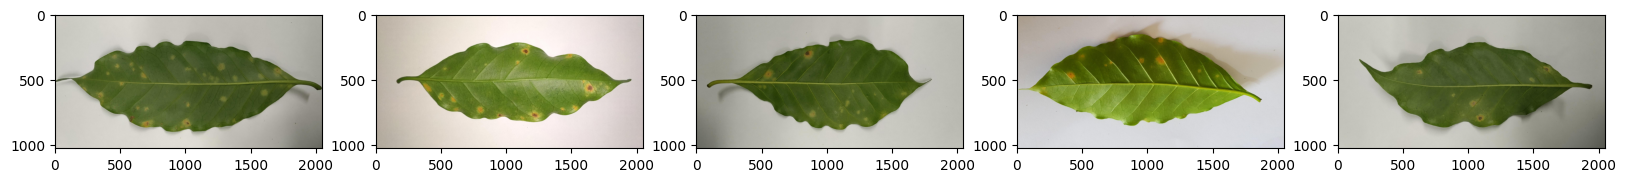

In [14]:
#checking image on directory
for  images in list_test_dir:
  print(images)
  class_dir = os.path.join(testing_directory,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

#**Preparing Image Data Generator**

In [15]:
def train_validation_test_generators(TRAINING_DIRECTORY, TESTING_DIRECTORY):

  # Instantiate the ImageDataGenerator class (train)
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     validation_split=0.2)

  # Pass in the appropriate arguments to the flow_from_directory method (train)
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIRECTORY,
                                                      batch_size=32,
                                                      target_size=(150, 150),
                                                      class_mode = 'categorical',
                                                      subset='training')

  # Pass in the appropriate arguments to the flow_from_directory method (validation)
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIRECTORY,
                                                          batch_size=32,
                                                          target_size=(150, 150),
                                                          class_mode='categorical',
                                                          subset='validation')

  # Instantiate the ImageDataGenerator class (test)
  test_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method (test)
  test_generator = test_datagen.flow_from_directory(directory=TESTING_DIRECTORY,
                                                    batch_size=32,
                                                    target_size=(150, 150),
                                                    class_mode = 'categorical',
                                                    shuffle=False)

  return train_generator, validation_generator, test_generator

In [16]:
train_generator, validation_generator, test_generator = train_validation_test_generators(training_directory, testing_directory)

Found 1013 images belonging to 4 classes.
Found 251 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [17]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)
num_labels = len(labels)

print("Labels: {}".format(labels))

Labels: ['miner', 'nodisease', 'phoma', 'rust']


In [18]:
def create_model1():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

  return model

In [19]:
model = create_model1()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('loss')<0.10):
      self.model.stop_training = True
      print("\nThe accuracy of the training set has reached > 95% and validating set has reached > 80%!")
callbacks = myCallback()

In [21]:
# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3086 - loss: 1.3993 - val_accuracy: 0.3187 - val_loss: 1.3629
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3352 - loss: 1.3692 - val_accuracy: 0.3227 - val_loss: 1.3535
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3981 - loss: 1.2419 - val_accuracy: 0.5060 - val_loss: 1.0856
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5662 - loss: 1.0161 - val_accuracy: 0.6056 - val_loss: 0.8239
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6734 - loss: 0.7274 - val_accuracy: 0.6215 - val_loss: 0.8434
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6681 - loss: 0.7708 - val_accuracy: 0.7729 - val_loss: 0.5379
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7348 - loss: 0.6259 - val_accuracy: 0.8526 - val_loss: 0.3649
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7972 - loss: 0.4878 - val_accuracy: 0.9084 - val_loss: 0.3377
Epo

In [22]:
score_train = model.evaluate(train_generator)
score_validation = model.evaluate(validation_generator)

print(f"Accuracy (train): {score_train[1] * 100:.2f}%")
print(f"Accuracy (validation): {score_validation[1] * 100:.2f}%")
print(f"Loss (train): {score_train[0] * 100:.2f}%")
print(f"Loss (validation): {score_validation[0] * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 833ms/step - accuracy: 0.9651 - loss: 0.1150
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 707ms/step - accuracy: 0.9321 - loss: 0.2477
Accuracy (train): 96.35%
Accuracy (validation): 92.03%
Loss (train): 11.02%
Loss (validation): 27.61%


#**Data Visualization**

In [23]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')

    plt.tight_layout()
    plt.show()

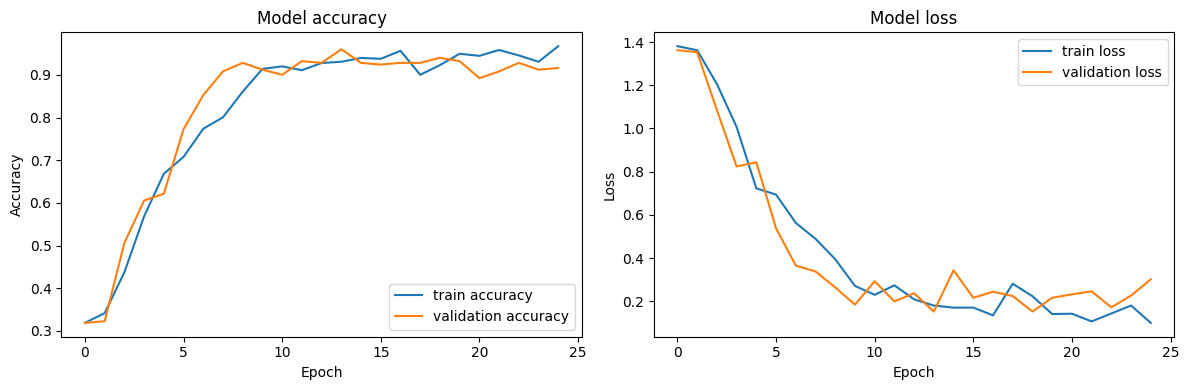

In [24]:
plot_training_history(history)

In [25]:
def eval_CM(y_test, y_pred, labels):
    cf_matrix3 = confusion_matrix(y_test, y_pred)

    ax3 = sns.heatmap(cf_matrix3, annot=True, fmt='g', cmap='Blues')

    ax3.set_title('Confusion Matrix with labels\n');
    ax3.set_xlabel('\nPredicted Values')
    ax3.set_ylabel('Actual Values ');

    ax3.xaxis.set_ticklabels(labels, rotation=45)
    ax3.yaxis.set_ticklabels(labels, rotation=45)

    return plt.show()

y_test = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = tf.argmax(y_pred, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 679ms/step


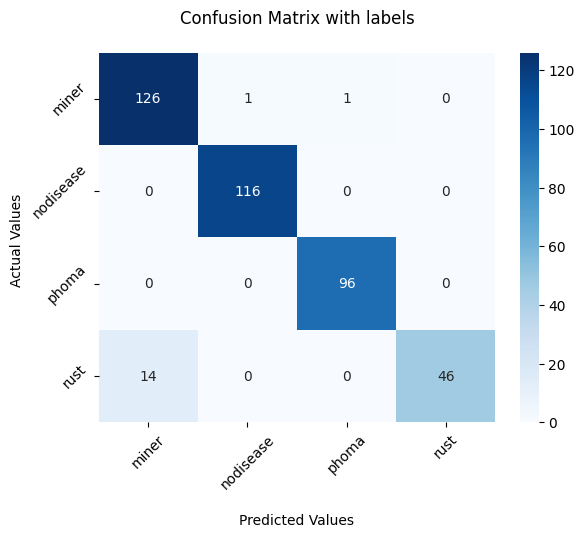

In [26]:
eval_CM(y_test, y_pred, labels)

In [35]:
print(train_generator.class_indices)
print()
print(classification_report(y_test, y_pred))

{'miner': 0, 'nodisease': 1, 'phoma': 2, 'rust': 3}

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       128
           1       0.99      1.00      1.00       116
           2       0.99      1.00      0.99        96
           3       1.00      0.77      0.87        60

    accuracy                           0.96       400
   macro avg       0.97      0.94      0.95       400
weighted avg       0.96      0.96      0.96       400



In [36]:
def predict_image(model, uploaded):
    img = image.load_img(uploaded, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    images /= 255

    classes = model.predict(images, batch_size=100)
    predicted_class_indices=np.argmax(classes)
    confidence = classes[0][predicted_class_indices]
    print(classes)

    # Output results
    print(f"Predicted file: {uploaded}")
    plt.show()
    if predicted_class_indices == 0: # Miner
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Miner:")
        print("- Pengelolaan Biologis: Gunakan predator alami seperti parasitoid (Diglyphus isaea) untuk mengendalikan populasi larva.")
        print("- Pengendalian Kimia: Semprotkan insektisida berbahan aktif seperti abamectin atau spinosad secara hati-hati untuk menghindari kerusakan ekosistem.")
        print("- Pencegahan: Pangkas dan buang daun yang terinfestasi untuk mencegah penyebaran lebih lanjut.")
    elif predicted_class_indices == 1: # No Disease
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Healthy (No disease):")
        print("- Pemeliharaan: Lakukan pemangkasan rutin untuk meningkatkan ventilasi dan paparan sinar matahari.")
        print("- Pemupukan: Berikan pupuk organik atau kimia sesuai kebutuhan tanaman.")
        print("- Monitoring: Lakukan pemantauan secara berkala untuk mendeteksi penyakit atau hama sejak dini.")
    elif predicted_class_indices == 2: # Phoma
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Phoma:")
        print("- Fungisida: Aplikasikan fungisida berbahan aktif seperti chlorothalonil atau mancozeb.")
        print("- Pengelolaan Tanaman: Pastikan jarak tanam yang cukup untuk meningkatkan sirkulasi udara di antara tanaman.")
        print("- Sanitasi Kebun: Buang daun yang terinfeksi dan bakar untuk mengurangi sumber inokulum.")
        print("- Pencegahan: Hindari penyiraman di atas daun, terutama pada sore hari, untuk mengurangi kelembapan berlebih.")
    elif predicted_class_indices == 3: # Rust
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Rust:")
        print("- Fungisida: Gunakan fungisida berbahan aktif seperti copper hydroxide atau propiconazole.")
        print("- Pengelolaan Lahan: Tanam varietas kopi yang tahan terhadap karat daun jika tersedia.")
        print("- Pemupukan: Pastikan tanaman mendapat nutrisi yang cukup, terutama nitrogen, fosfor, dan kalium, untuk meningkatkan daya tahan terhadap penyakit.")
        print("- Pembersihan Kebun: Singkirkan daun yang gugur dan terinfeksi untuk mengurangi sumber penyakit.")
    else:
        print('???')

    print(f"Confidence: {confidence:.2%}")  # Convert to percentage

Saving miner.jpg to miner.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[9.9756730e-01 1.2505658e-16 2.7209461e-09 2.4327105e-03]]
Predicted file: miner.jpg


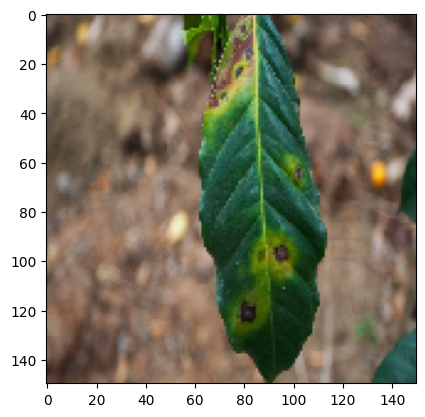

Predicted class: miner
Solution for Miner:
- Pengelolaan Biologis: Gunakan predator alami seperti parasitoid (Diglyphus isaea) untuk mengendalikan populasi larva.
- Pengendalian Kimia: Semprotkan insektisida berbahan aktif seperti abamectin atau spinosad secara hati-hati untuk menghindari kerusakan ekosistem.
- Pencegahan: Pangkas dan buang daun yang terinfestasi untuk mencegah penyebaran lebih lanjut.
Confidence: 99.76%


In [39]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Mendapatkan nama file yang di-upload

predict_image(model, image_path)

#**Export Model**

In [40]:
model.save('cofflyze_model1.h5')

loaded_model = tf.keras.models.load_model('cofflyze_model1.h5')

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Accuracy (Loaded Model): {test_accuracy * 100:.2f}%")
print(f"Test Loss (Loaded Model): {test_loss * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 791ms/step - accuracy: 0.9815 - loss: 0.0617
Test Accuracy (Loaded Model): 96.00%
Test Loss (Loaded Model): 17.24%


In [41]:
model = tf.keras.models.load_model('cofflyze_model1.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('cofflyze_model1.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite!")

Saved artifact at '/tmp/tmpd6d3csk1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133159998323552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133160003575072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987429616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987433136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987443872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987441936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987631504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987626224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987642064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987639776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987641712

In [42]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_optimized = converter.convert()

with open('cofflyze_model1.tflite', 'wb') as f:
    f.write(tflite_model_optimized)

print("Model dengan optimisasi berhasil dibuat!")

Saved artifact at '/tmp/tmpv5cu6b3z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133159998323552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133160003575072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987429616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987433136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987443872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987441936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987631504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987626224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987642064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987639776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133159987641712

In [43]:
labels = ['phoma', 'miner', 'nodisease', 'rust']

with open("labels.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

print("File labels.txt telah dibuat!")

File labels.txt telah dibuat!


In [44]:
ImageClassifierWriter = image_classifier.MetadataWriter

MODEL_PATH = "cofflyze_model1.tflite"
LABEL_FILE = "labels.txt"
SAVE_TO_PATH = "cofflyze_model1_with_metadata.tflite"

INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(MODEL_PATH), [INPUT_NORM_MEAN], [INPUT_NORM_STD], [LABEL_FILE])

# Verify the metadata generated by the metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

In [49]:
displayer = MetadataDisplayer.with_model_file("cofflyze_model_with_metadata.tflite")
print(displayer.get_metadata_json())

NameError: name 'MetadataDisplayer' is not defined